custom images steps:

* resized a few
* converted all to jpg
* created zip file with seth-faces/images/ammonX or sethX

**How to copy file to VM**

gcloud compute scp --project "maximal-grin-177817" --zone "us-central1-c" ./seth-faces.zip jupyter@fastai-preemptible:/home/jupyter/

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [3]:
# now get my data - already unziped to data folder
path=Path('/home/jupyter/fastai_data/seth-faces')
path_img = path/'images'
path.ls()

[PosixPath('/home/jupyter/fastai_data/seth-faces/.DS_Store'),
 PosixPath('/home/jupyter/fastai_data/seth-faces/images')]

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/fastai_data/seth-faces/images/ammon.10.jpg'),
 PosixPath('/home/jupyter/fastai_data/seth-faces/images/ammon.13.jpg'),
 PosixPath('/home/jupyter/fastai_data/seth-faces/images/seth.18.jpg'),
 PosixPath('/home/jupyter/fastai_data/seth-faces/images/seth.19.jpg'),
 PosixPath('/home/jupyter/fastai_data/seth-faces/images/ammon.07.jpg')]

**To check pattern**

```
pat = r'/([^/.]+).\d+\w*.jpg$'
pat = re.compile(pat)

for s in fnames:
    print(pat.search(str(s)).group(1))
```

In [5]:
np.random.seed(42)
pat = r'/([^/.]+).\d+\w*.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64)

In [6]:
data.normalize(imagenet_stats)

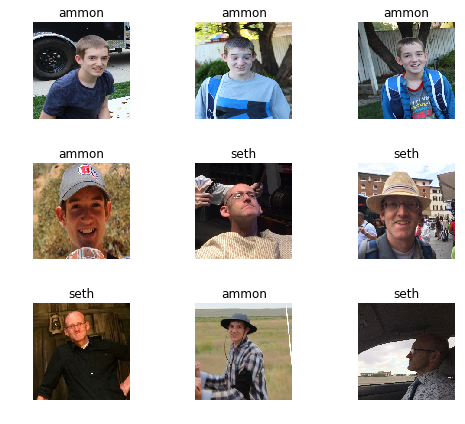

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['ammon', 'seth']


(2, 2)

### 20 Images

With the resenet50 model and 20 images of each person, we can only get to 84% accuracy - though this varies from run to run.

```
Total time: 00:37
epoch  train_loss  valid_loss  error_rate
1      0.922177    0.831953    0.750000    (00:06)
2      0.825071    0.886139    0.583333    (00:04)
3      0.597994    0.902047    0.500000    (00:04)
4      0.455691    0.878664    0.416667    (00:04)
5      0.371805    0.862705    0.333333    (00:04)
6      0.312212    0.809088    0.250000    (00:04)
7      0.267372    0.755920    0.166667    (00:04)
8      0.232702    0.691001    0.166667    (00:04)
```

With the resnet34 model and 20 images of each person, we can only get to 59% accuracy. From inspecting results later on, it appears to be predicting Seth more than it should

```
Total time: 00:33
epoch  train_loss  valid_loss  error_rate
1      0.965038    0.631979    0.250000    (00:04)
2      0.998025    0.685143    0.416667    (00:04)
3      0.895424    0.830498    0.500000    (00:04)
4      0.710613    0.932535    0.583333    (00:04)
5      0.581470    0.982498    0.500000    (00:04)
6      0.496383    0.985610    0.500000    (00:04)
7      0.428599    0.962966    0.416667    (00:04)
8      0.375984    0.940846    0.416667    (00:04)
```

In [9]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
#learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(8)

Total time: 00:37
epoch  train_loss  valid_loss  error_rate
1      1.035739    0.683083    0.333333    (00:06)
2      0.930890    0.634520    0.333333    (00:04)
3      0.669958    0.536694    0.250000    (00:04)
4      0.516205    0.478382    0.333333    (00:04)
5      0.415742    0.450515    0.250000    (00:04)
6      0.345948    0.440266    0.250000    (00:04)
7      0.294269    0.431549    0.250000    (00:04)
8      0.255409    0.418278    0.250000    (00:04)



In [10]:
interp = ClassificationInterpretation.from_learner(learn)

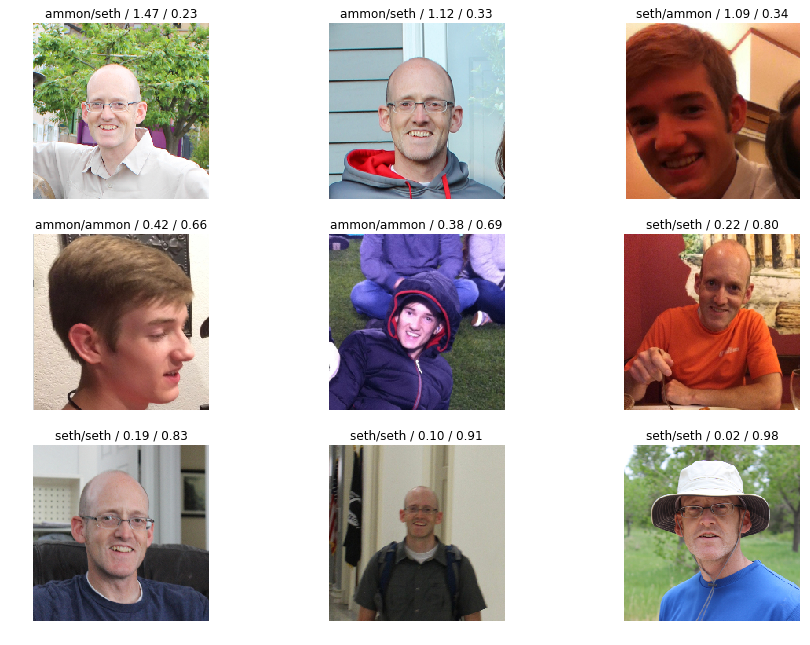

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

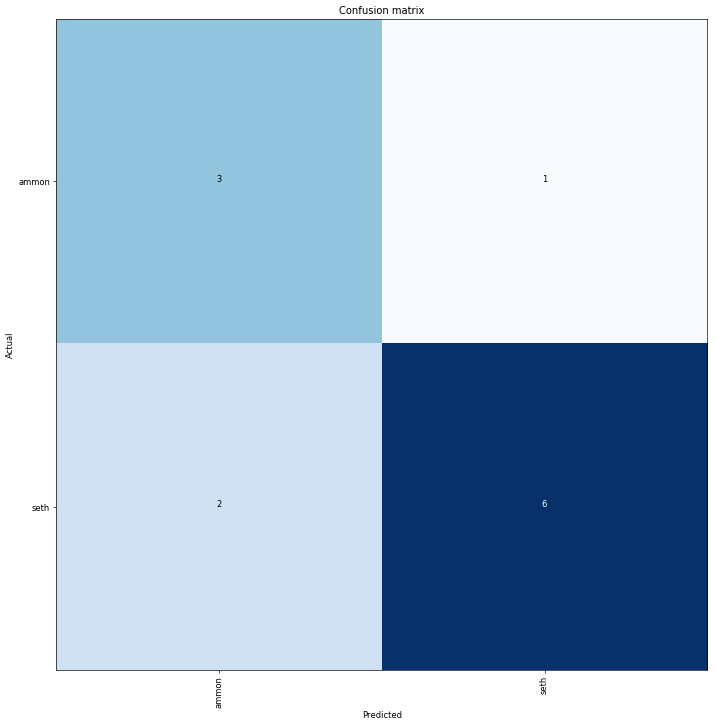

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


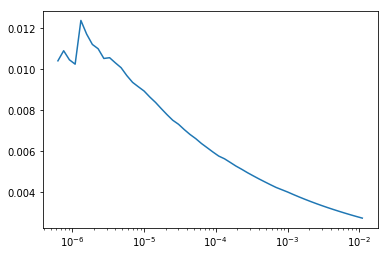

In [13]:
# unfreeze model to attempt to fine tune futher.
learn.unfreeze()
# search for better learning rate for this data set
learn.lr_find()
# visualize learning rate
learn.recorder.plot()

This graph is pretty much the opposite of the graphs from lesson 1 - a larger learning rate is better; the higher the rate the better it performs

However, training loss is only 1%, so it seems to be over fitting

In [14]:
learn.fit_one_cycle(1, max_lr=slice(1e-4,1e-2))

Total time: 00:04
epoch  train_loss  valid_loss  error_rate
1      0.024290    0.433804    0.333333    (00:04)

